# Stylized Facts about stock returns

see reference http://rama.cont.perso.math.cnrs.fr/pdf/empirical.pdf

In [ ]:
import itertools
import datetime as dt

import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import yfinance as yf

In [ ]:
np.random.seed(42)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

colors = [color_dark_blue, color_light_blue, purple]

color_line = list(itertools.product(['-', ':', '--', ':' '-', ':'], colors))

## S&P 500 data and log-returns



In [ ]:
today = dt.date.today().strftime('%Y-%m-%d')
start = '2015-01-01'

In [ ]:
spx_ticker = yf.Ticker("^SPX")
df = spx_ticker.history(start=start, end=today)['Close']
df.index = pd.to_datetime(df.index.date, format='%Y-%m-%d')

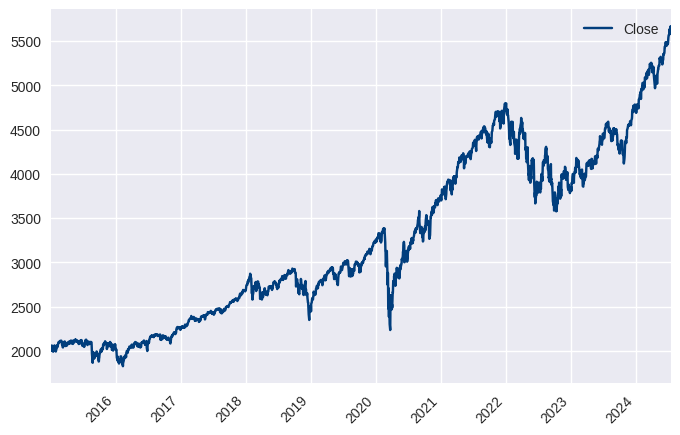

In [ ]:
df.plot(color=color_line[0][1], linestyle=color_line[0][0])
plt.legend(fontsize="10")
plt.xticks(rotation=45, ha='right')
plt.xlim([df.index[0], df.index[-1]])
plt.show()

### Log-return

$\displaystyle R_i = \log\left(\frac{S_{t_i}}{S_{t_{i-1}}}\right)$

In [ ]:
daily_return = np.log(df).diff().dropna()
weekly_return = np.log(df.resample('W').last()).diff().dropna()
monthly_return = np.log(df.resample('M').last()).diff().dropna()

## Stylized Fact 5: Intermittency

returns display, at any time scale, a high
degree of variability. This is quantified by the presence of
irregular bursts in time series of a wide variety of volatility
estimators

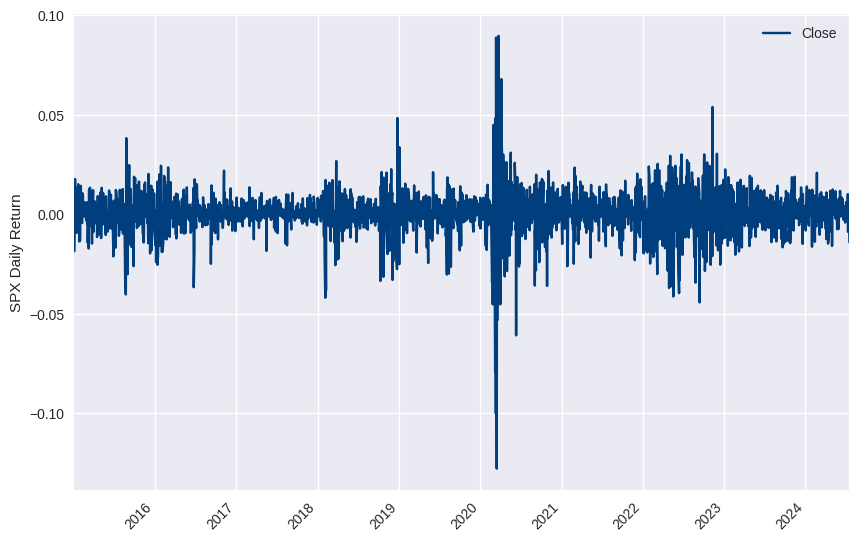

In [ ]:
daily_return.plot(figsize=(10, 7), color=color_line[0][1], linestyle=color_line[0][0])
plt.legend(fontsize="10")
plt.xticks(rotation=45, ha='right')
plt.xlim([daily_return.index[0], daily_return.index[-1]]);
plt.ylabel('SPX Daily Return');

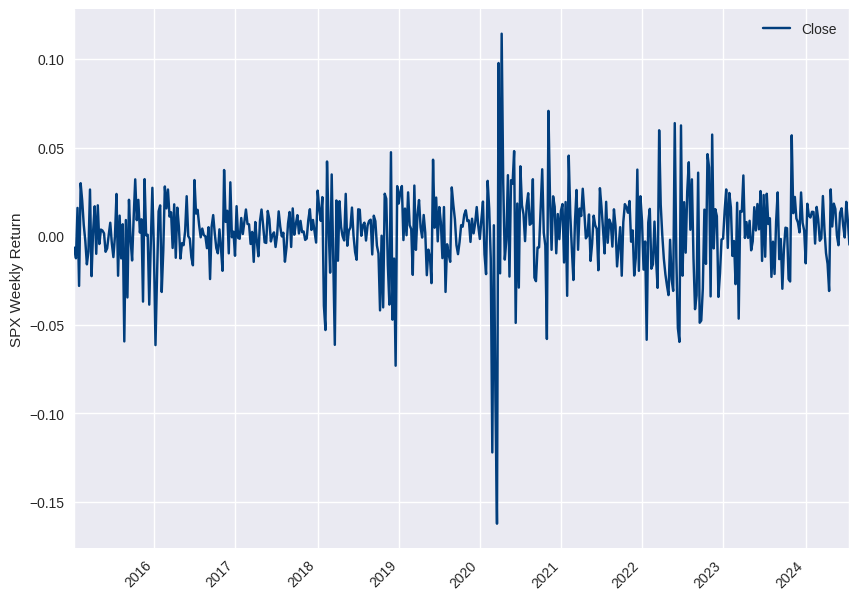

In [ ]:
weekly_return.plot(figsize=(10, 7), color=color_line[0][1], linestyle=color_line[0][0])
plt.legend(fontsize="10")
plt.xticks(rotation=45, ha='right')
plt.xlim([weekly_return.index[0], weekly_return.index[-1]]);
plt.ylabel('SPX Weekly Return');

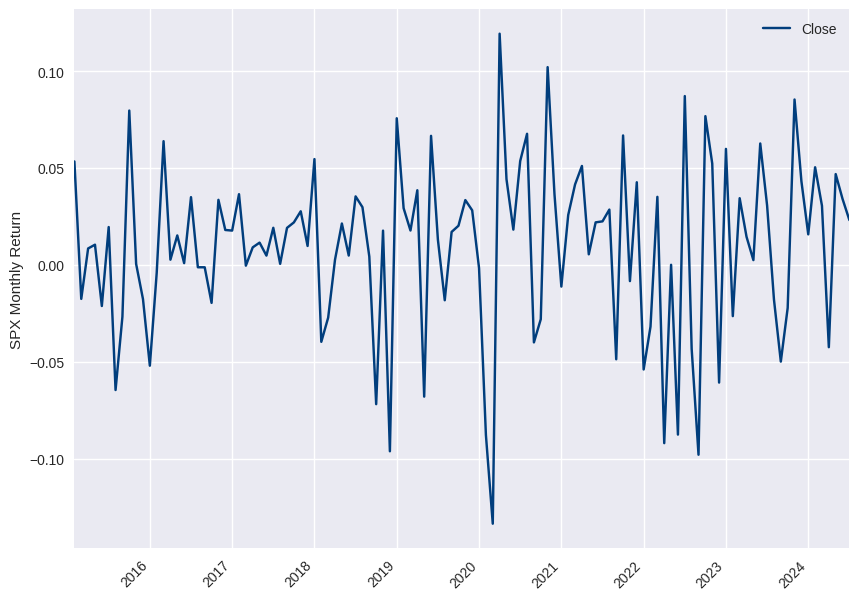

In [ ]:
monthly_return.plot(figsize=(10, 7), color=color_line[0][1], linestyle=color_line[0][0])
plt.legend(fontsize="10")
plt.xticks(rotation=45, ha='right')
plt.xlim([monthly_return.index[0], monthly_return.index[-1]]);
plt.ylabel('SPX Monthly Return');

## Stylized Fact 1: Absence of autocorrelations

(linear) autocorrelations
of asset returns are often insignificant, except for very
small intraday time scales ( 20 minutes) for which
microstructure effects come into play

$$\rho_k = \mbox{Corr}(R_{t_i}, R_{t_{i+k}})$$

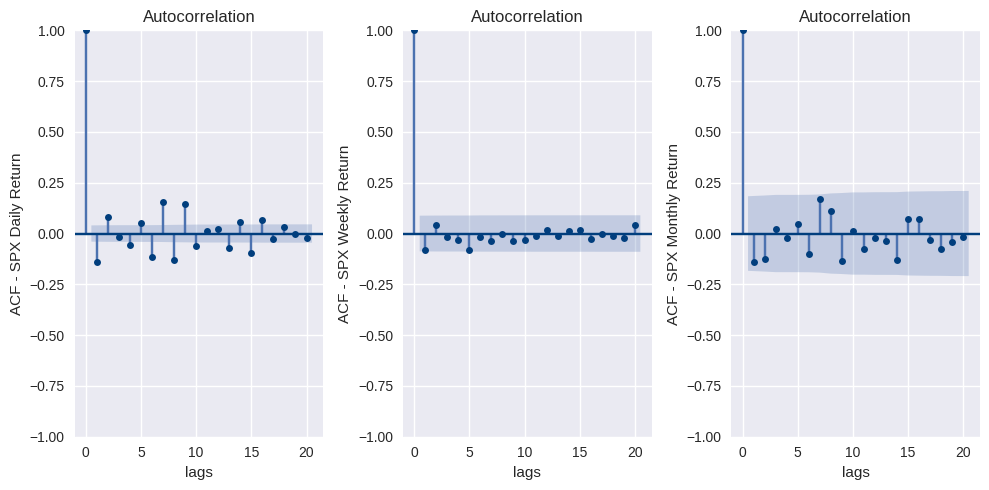

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(131)
sm.graphics.tsa.plot_acf(daily_return, lags=20, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Daily Return')

ax = fig.add_subplot(132)
sm.graphics.tsa.plot_acf(weekly_return, lags=20, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Weekly Return')

ax = fig.add_subplot(133)
sm.graphics.tsa.plot_acf(monthly_return, lags=20, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Monthly Return')

plt.tight_layout()


## Stylized Facts 2, 3 and 4: Heavy tails, Gain/loss asymmetry, Aggregational Gaussianity

- the (unconditional) distribution of returns
seems to display a power-law or Pareto-like tail, with
a tail index which is finite, higher than two and less
than five for most data sets studied. In particular this
excludes stable laws with infinite variance and the normal
distribution. However the precise form of the tails is
difficult to determine.

- one observes large drawdowns in
stock prices and stock index values but not equally large
upward movements (This property is not true for exchange rates where there is a higher symmetry
in up/down moves.)

- as one increases the
time scale $\Delta t$ over which returns are calculated,
their distribution looks more and more like a normal
distribution. In particular, the shape of the distribution
is not the same at different time scales.

$\displaystyle \mu = \mathbb{E}[X]$

$\displaystyle \sigma^2 = \mathbb{E}\left[(X - \mu)^2 \right]$

$\displaystyle \text{Skew}(X) = \mathbb{E}\left[\left(\frac{X - \mu}{\sigma}\right)^3 \right]$

$\displaystyle \text{Kurt}(X) = \mathbb{E}\left[\left(\frac{X - \mu}{\sigma}\right)^4 \right]$

In [ ]:
print('Skewness Daily Return: ', skew(daily_return, axis=0, bias=True))
print('Skewness Weekly Return: ', skew(weekly_return, axis=0, bias=True))
print('Skewness Monthly Return: ', skew(monthly_return, axis=0, bias=True))

Skewness Daily Return:  -0.8052751236455284
Skewness Weekly Return:  -0.9368458889551086
Skewness Monthly Return:  -0.5264246069003198


In [ ]:
print('Kurtosis Daily Return: ', kurtosis(daily_return, axis=0, bias=True)+3)
print('Kurtosis Weekly Return: ', kurtosis(weekly_return, axis=0, bias=True)+3)
print('Kurtosis Monthly Return: ', kurtosis(monthly_return, axis=0, bias=True)+3)

Kurtosis Daily Return:  18.913001580372843
Kurtosis Weekly Return:  10.71741572593329
Kurtosis Monthly Return:  3.5558461060281634


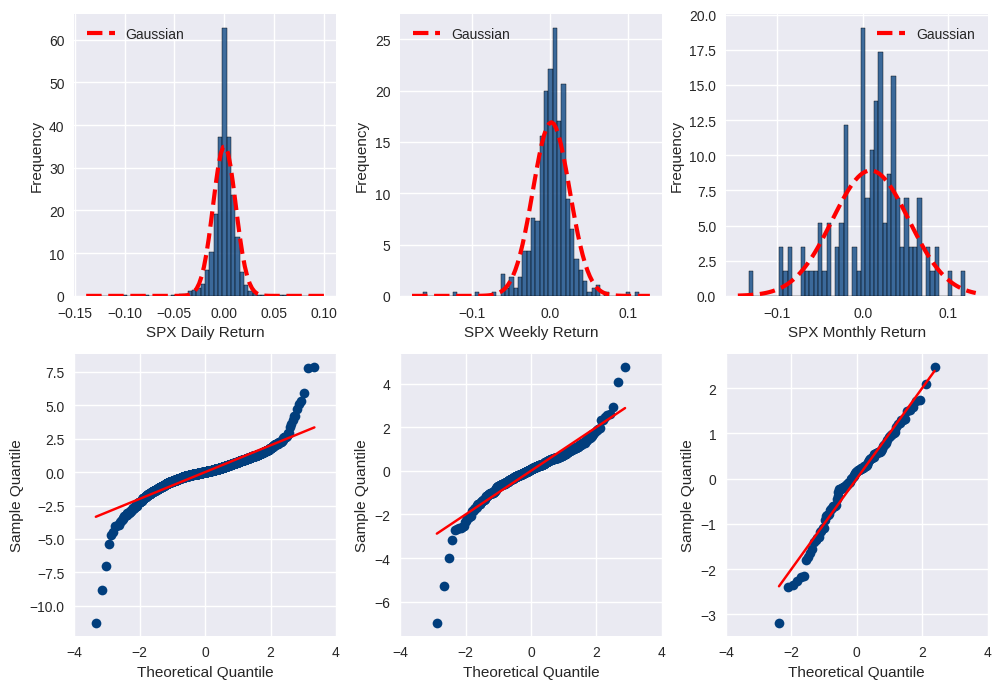

In [ ]:
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(231)
sns.histplot(daily_return, bins=50, color=color_dark_blue, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(daily_return), np.std(daily_return))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel('SPX Daily Return')
plt.ylabel('Frequency')
plt.legend()

ax = fig.add_subplot(234)
qq = qqplot(daily_return, line='s', ax=ax, markerfacecolor=color_dark_blue, fit=True)
plt.xlabel('Theoretical Quantile')
plt.ylabel('Sample Quantile')
plt.xlim([-4,4]);

ax = fig.add_subplot(232)
sns.histplot(weekly_return, bins=50, color=color_dark_blue, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(weekly_return), np.std(weekly_return))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel('SPX Weekly Return')
plt.ylabel('Frequency')
plt.legend()

ax = fig.add_subplot(235)
qq = qqplot(weekly_return, line='s', ax=ax, markerfacecolor=color_dark_blue, fit=True)
plt.xlabel('Theoretical Quantile')
plt.ylabel('Sample Quantile')
plt.xlim([-4,4]);

ax = fig.add_subplot(233)
sns.histplot(monthly_return, bins=50, color=color_dark_blue, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(monthly_return), np.std(monthly_return))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel('SPX Monthly Return')
plt.ylabel('Frequency')
plt.legend()

ax = fig.add_subplot(236)
qq = qqplot(monthly_return, line='s', ax=ax, markerfacecolor=color_dark_blue, fit=True)
plt.xlabel('Theoretical Quantile')
plt.ylabel('Sample Quantile')
plt.xlim([-4,4]);

plt.tight_layout()

# Advanced Stylized Facts

## Stylized Fact 6: Volatility clustering

different measures of volatility
display a positive autocorrelation over several days, which
quantifies the fact that high-volatility events tend to cluster
in time.

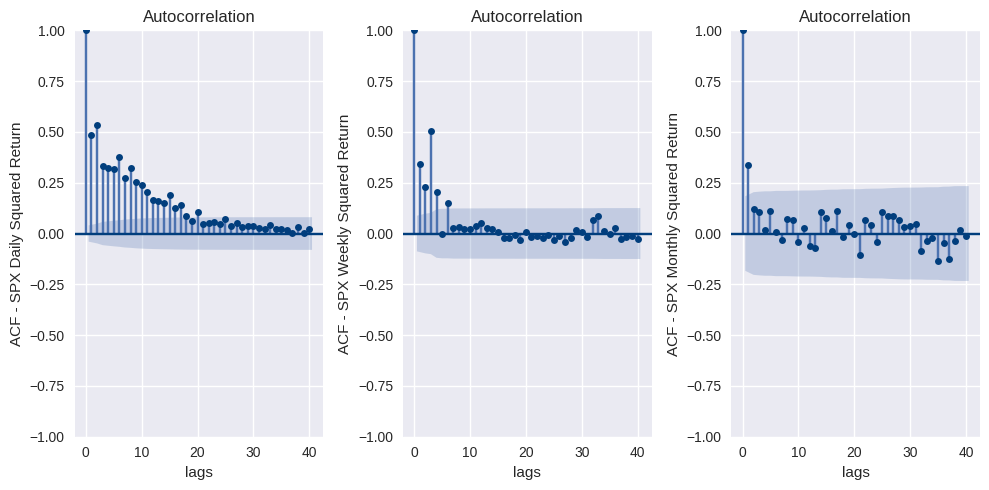

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(131)
sm.graphics.tsa.plot_acf(daily_return**2, lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Daily Squared Return')

ax = fig.add_subplot(132)
sm.graphics.tsa.plot_acf(weekly_return**2, lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Weekly Squared Return')

ax = fig.add_subplot(133)
sm.graphics.tsa.plot_acf(monthly_return**2, lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Monthly Squared Return')

plt.tight_layout()

## Stylized Fact 8:  Slow decay of autocorrelation in absolute returns:

the
autocorrelation function of absolute returns decays slowly
as a function of the time lag, roughly as a power law with
an exponent β ∈ [0.2, 0.4]. This is sometimes interpreted
as a sign of long-range dependence.

$$c_k = \mbox{Corr}(|R_{t_i}|, |R_{t_{i+k}}|) \sim \frac{a}{k^\beta}$$

In [ ]:
def power(x, a, b):
    return a / np.power(x, b)

initial_guess = [1, 1]
lags = np.arange(1, 41)
daily_abs_acf = sm.tsa.stattools.acf(np.abs(daily_return), nlags=lags[-1]-1)
weekly_abs_acf = sm.tsa.stattools.acf(np.abs(weekly_return), nlags=lags[-1]-1)
monthly_abs_acf = sm.tsa.stattools.acf(np.abs(monthly_return), nlags=lags[-1]-1)

popt_daily, pcov_daily = curve_fit(power, lags[1:], daily_abs_acf[1:], p0=initial_guess, maxfev=5000)
popt_weekly, pcov_weekly = curve_fit(power, lags[1:], weekly_abs_acf[1:], p0=initial_guess, maxfev=5000)
popt_monthly, pcov_monthly = curve_fit(power, lags[1:], monthly_abs_acf[1:], p0=initial_guess, maxfev=5000)

In [ ]:
print('Power law for Daily Return: ', popt_daily)
print('Power law for Weekly Return: ', popt_weekly)
print('Power law for Monthly Return: ', popt_monthly)

Power law for Daily Return:  [0.71272559 0.44947204]
Power law for Weekly Return:  [0.78674859 0.93307989]
Power law for Monthly Return:  [0.45675101 0.87370942]


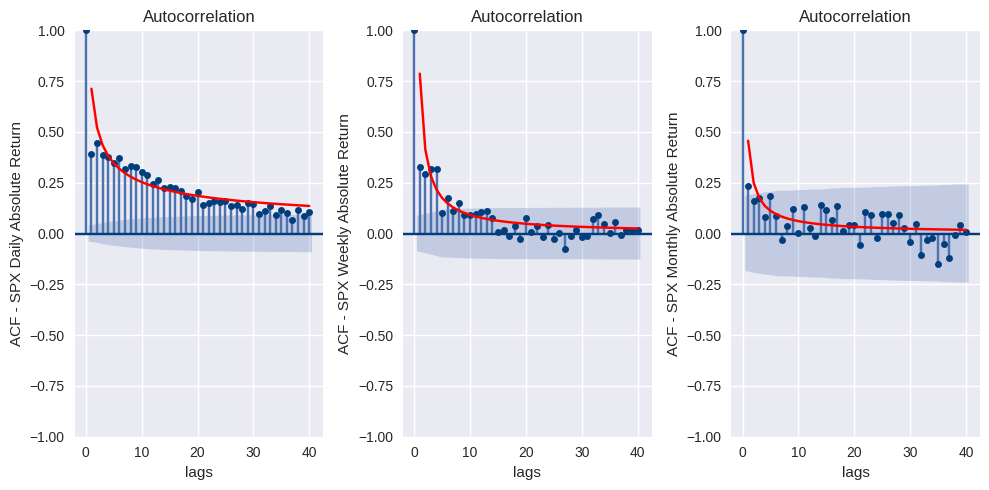

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(131)
sm.graphics.tsa.plot_acf(np.abs(daily_return), lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
ax.plot(lags, power(lags, *popt_daily), 'r-')
plt.xlabel('lags')
plt.ylabel('ACF - SPX Daily Absolute Return')

ax = fig.add_subplot(132)
sm.graphics.tsa.plot_acf(np.abs(weekly_return), lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
ax.plot(lags, power(lags, *popt_weekly), 'r-')
plt.xlabel('lags')
plt.ylabel('ACF - SPX Weekly Absolute Return')

ax = fig.add_subplot(133)
sm.graphics.tsa.plot_acf(np.abs(monthly_return), lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
ax.plot(lags, power(lags, *popt_monthly), 'r-')
plt.xlabel('lags')
plt.ylabel('ACF - SPX Monthly Absolute Return')

plt.tight_layout()

## Stylized Fact 7:  Conditional heavy tails

even after correcting returns for
volatility clustering (e.g. via GARCH-type models), the
residual time series still exhibit heavy tails. However, the
tails are less heavy than in the unconditional distribution
of returns.

In [ ]:
!pip3 install arch
from arch import arch_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 11.5 MB/s eta 0:00:00


In [ ]:
garch = arch_model(100*daily_return, vol='GARCH', p=1, q=1, dist='gaussian')
daily_res_fit = garch.fit(update_freq=0, disp="off")
daily_std_resid = pd.Series(daily_res_fit.resid / daily_res_fit.conditional_volatility)

garch = arch_model(100*weekly_return, vol='GARCH', p=1, q=1, dist='gaussian')
weekly_res_fit = garch.fit(update_freq=0, disp="off")
weekly_std_resid = pd.Series(weekly_res_fit.resid / weekly_res_fit.conditional_volatility)

garch = arch_model(100*monthly_return, vol='GARCH', p=1, q=1, dist='gaussian')
monthly_res_fit = garch.fit(update_freq=0, disp="off")
monthly_std_resid = pd.Series(monthly_res_fit.resid / monthly_res_fit.conditional_volatility)

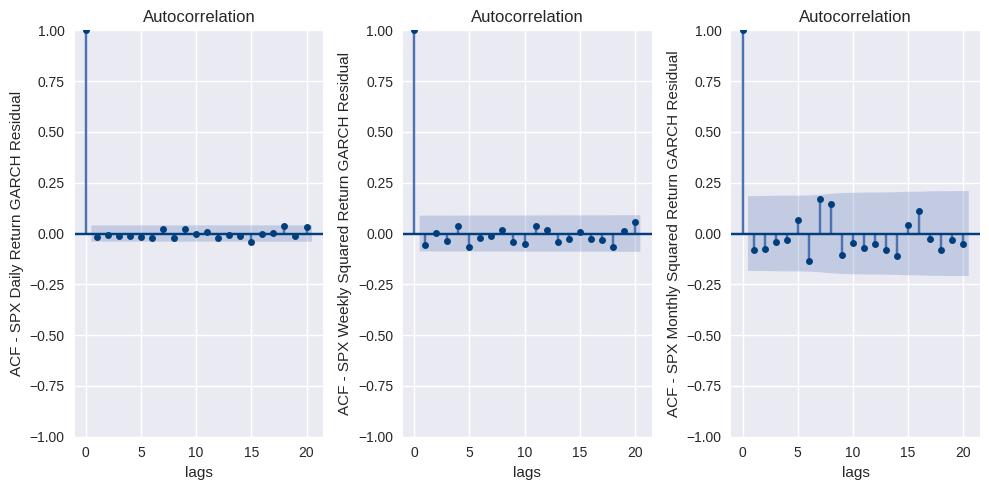

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(131)
sm.graphics.tsa.plot_acf(daily_std_resid, lags=20, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Daily Return GARCH Residual')

ax = fig.add_subplot(132)
sm.graphics.tsa.plot_acf(weekly_std_resid, lags=20, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Weekly Squared Return GARCH Residual')

ax = fig.add_subplot(133)
sm.graphics.tsa.plot_acf(monthly_std_resid, lags=20, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Monthly Squared Return GARCH Residual')

plt.tight_layout()

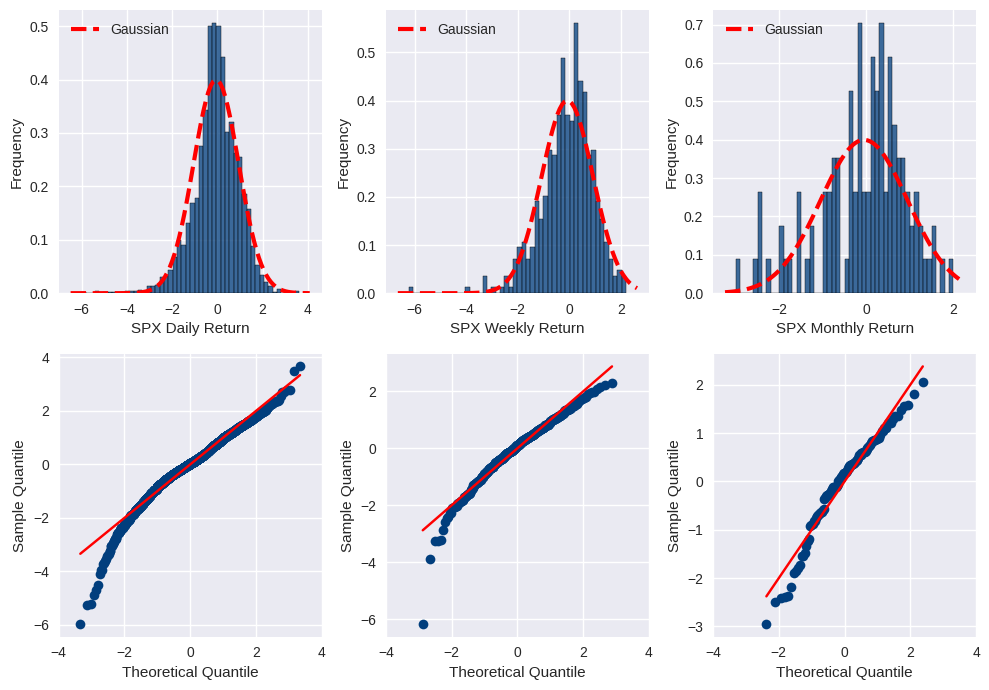

In [ ]:
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(231)
sns.histplot(daily_std_resid, bins=50, color=color_dark_blue, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(daily_std_resid), np.std(daily_std_resid))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel('SPX Daily Return')
plt.ylabel('Frequency')
plt.legend()

ax = fig.add_subplot(234)
qq = qqplot(daily_std_resid, line='s', ax=ax, markerfacecolor=color_dark_blue, fit=True)
plt.xlabel('Theoretical Quantile')
plt.ylabel('Sample Quantile')
plt.xlim([-4,4]);

ax = fig.add_subplot(232)
sns.histplot(weekly_std_resid, bins=50, color=color_dark_blue, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(weekly_std_resid), np.std(weekly_std_resid))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel('SPX Weekly Return')
plt.ylabel('Frequency')
plt.legend()

ax = fig.add_subplot(235)
qq = qqplot(weekly_std_resid, line='s', ax=ax, markerfacecolor=color_dark_blue, fit=True)
plt.xlabel('Theoretical Quantile')
plt.ylabel('Sample Quantile')
plt.xlim([-4,4]);

ax = fig.add_subplot(233)
sns.histplot(monthly_std_resid, bins=50, color=color_dark_blue, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(monthly_std_resid), np.std(monthly_std_resid))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel('SPX Monthly Return')
plt.ylabel('Frequency')
plt.legend()

ax = fig.add_subplot(236)
qq = qqplot(monthly_std_resid, line='s', ax=ax, markerfacecolor=color_dark_blue, fit=True)
plt.xlabel('Theoretical Quantile')
plt.ylabel('Sample Quantile')
plt.xlim([-4,4]);

plt.tight_layout()

## Stylized fact 9: Leverage effect

most measures of volatility of an asset
are negatively correlated with the returns of that asset. "The theory claims that a price drop in a certain stock
will decrease the value of the firm’s equity, hence increase the leverage-ratio
since the value of the debt will remain the same. The increased leverage-ratio
will, in turn, impose higher risk on the equity and the stock will be more volatile
during next period."

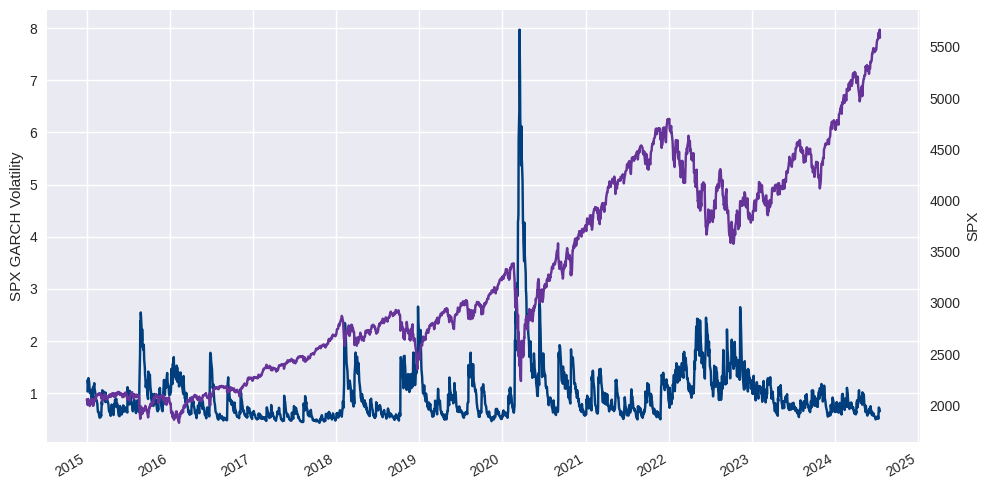

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
daily_res_fit.conditional_volatility.plot(color=color_line[0][1], linestyle=color_line[0][0])
plt.ylabel('SPX GARCH Volatility')
df.plot(color=purple, linestyle=color_line[0][0], secondary_y=True)
plt.ylabel('SPX')
plt.xlabel('Time')

# ax = fig.add_subplot(312)
# weekly_res_fit.conditional_volatility.plot(color=color_line[0][1], linestyle=color_line[0][0])
# plt.ylabel('SPX Weekly Return Volatility')
# plt.xlabel('Time')

# ax = fig.add_subplot(313)
# monthly_res_fit.conditional_volatility.plot(color=color_line[0][1], linestyle=color_line[0][0])
# plt.ylabel('SPX Monthly Return Volatility')
# plt.xlabel('Time')

plt.tight_layout()

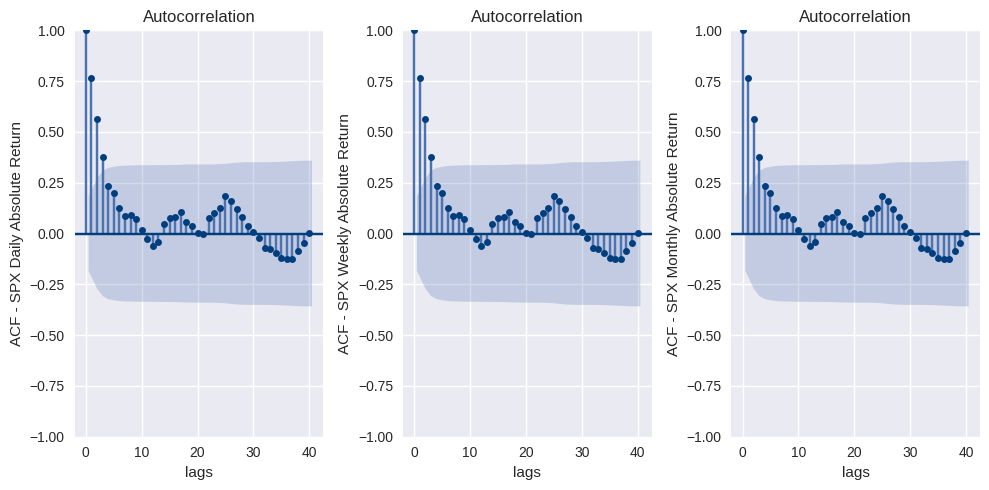

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(131)
sm.graphics.tsa.plot_acf(monthly_res_fit.conditional_volatility, lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Daily Absolute Return')

ax = fig.add_subplot(132)
sm.graphics.tsa.plot_acf(monthly_res_fit.conditional_volatility, lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Weekly Absolute Return')

ax = fig.add_subplot(133)
sm.graphics.tsa.plot_acf(monthly_res_fit.conditional_volatility, lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Monthly Absolute Return')

plt.tight_layout()

### Comparing with VIX

In [ ]:
vix_ticker = yf.Ticker("^VIX")
vix_data = vix_ticker.history(start=df.index[0], end=df.index[-1])['Close']

In [ ]:
df = df.iloc[:-1]
vix_data.index = pd.to_datetime(vix_data.index.date, format='%Y-%m-%d')
vix_data = vix_data[df.index]

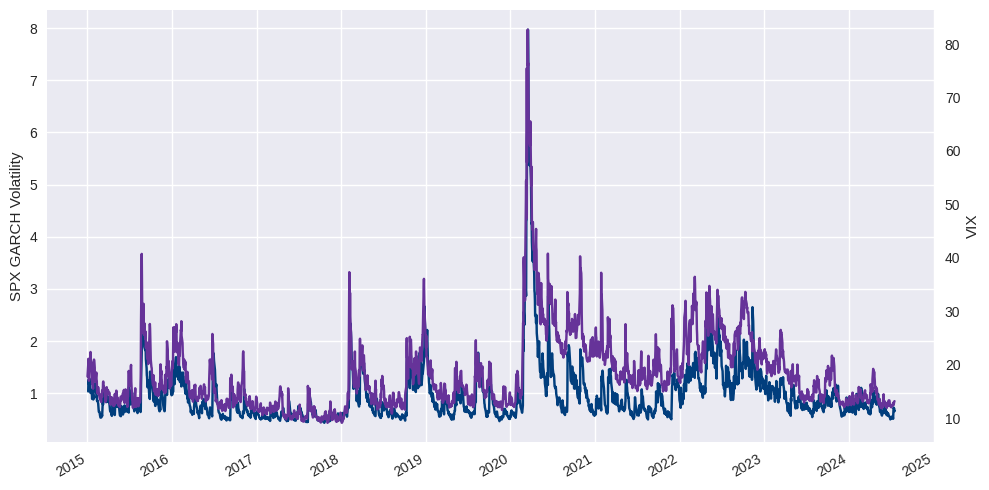

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
daily_res_fit.conditional_volatility.plot(color=color_line[0][1], linestyle=color_line[0][0])
plt.ylabel('SPX GARCH Volatility')
vix_data.plot(color=purple, linestyle=color_line[0][0], secondary_y=True)
plt.ylabel('VIX')
plt.xlabel('Time')

plt.tight_layout()

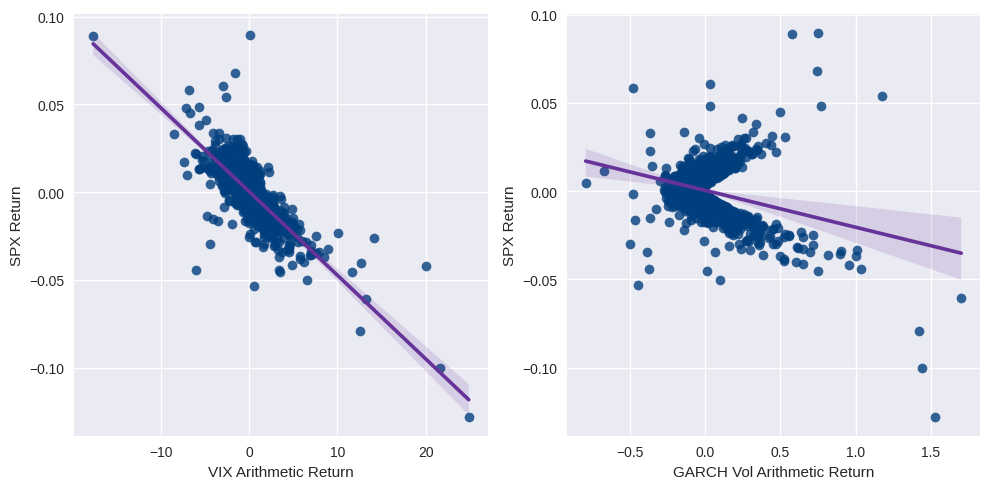

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
sns.regplot(x=vix_data.diff().dropna(), y=daily_return.iloc[:-1], color=color_dark_blue, line_kws=dict(color=purple))
plt.ylabel('SPX Return')
plt.xlabel('VIX Arithmetic Return')

ax = fig.add_subplot(122)
sns.regplot(x=daily_res_fit.conditional_volatility.diff().dropna(), y=daily_return.iloc[:-1], color=color_dark_blue, line_kws=dict(color=purple))
plt.ylabel('SPX Return')
plt.xlabel('GARCH Vol Arithmetic Return')

plt.tight_layout()

However this effect is asymmetric, in general the correlation is negligible between $\Delta \log(S_t)$ and $\sigma_{t+1}$

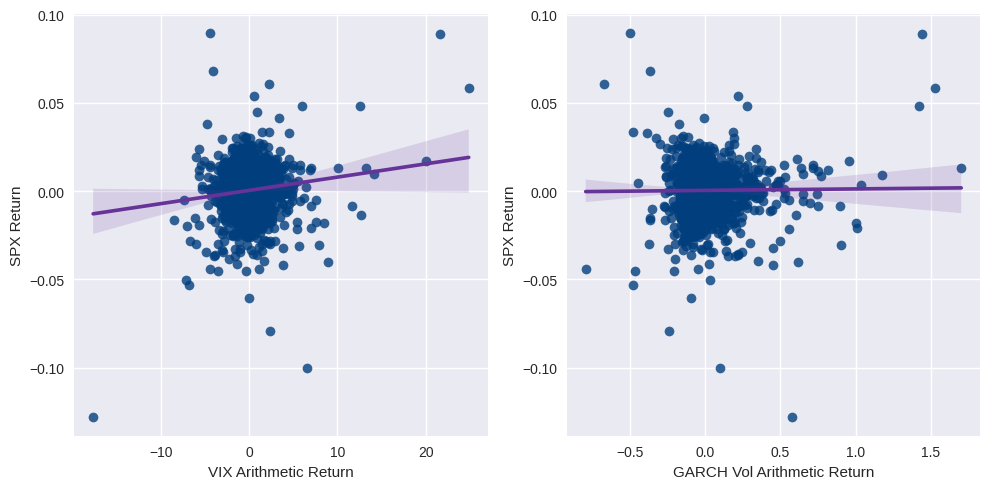

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
sns.regplot(x=vix_data.diff().dropna(), y=daily_return.iloc[1:], color=color_dark_blue, line_kws=dict(color=purple))
plt.ylabel('SPX Return')
plt.xlabel('VIX Arithmetic Return')

ax = fig.add_subplot(122)
sns.regplot(x=daily_res_fit.conditional_volatility.diff().dropna(), y=daily_return.iloc[1:], color=color_dark_blue, line_kws=dict(color=purple))
plt.ylabel('SPX Return')
plt.xlabel('GARCH Vol Arithmetic Return')

plt.tight_layout()

# Value at Risk Using GARCH

Gaussian noise - Number of 5% exceedance: 1.69%


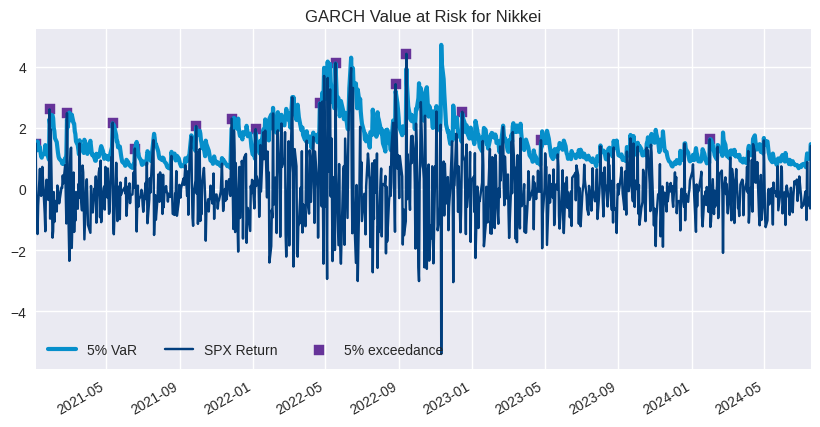

In [ ]:
am = arch_model(100*daily_return, vol="Garch", p=1, q=1, dist='gaussian')
res = am.fit(disp="off", last_obs=dt.datetime(2020,12,31))

forecasts = res.forecast(start=dt.datetime(2021,1,1), reindex=False)
cond_mean = forecasts.mean["2021":]
cond_var = forecasts.variance["2021":]
q = am.distribution.ppf([0.05])#, res.params[-1:])

value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q
value_at_risk = pd.DataFrame(value_at_risk, columns=["5% VaR"], index=cond_var.index)


ax = value_at_risk.plot(figsize=(10,5),legend=False,color=color_light_blue)

rets = 100*daily_return["2021":].copy()
rets.name = "SPX Return"
(-rets).plot(color=color_dark_blue)

for line in ax.get_lines():
    if line.get_label() == "5% VaR":
        line.set_linewidth(3)

c = []
ret_index_var = []
ret_var = []

five = 0

for idx in value_at_risk.index:
    if rets[idx] <= -value_at_risk.loc[idx, "5% VaR"]:
        five = five + 1
        ret_index_var.append(idx)
        ret_var.append(-rets.loc[idx])

ax.scatter(
    ret_index_var,
    ret_var,
    marker="s",
    c=[purple],
    label="5% exceedance",
)

ax.set_title("GARCH Value at Risk for Nikkei")
leg = ax.legend(frameon=False, ncol=3)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])

print("Gaussian noise - Number of 5% exceedance: {:.2f}%".format(100*five/len(value_at_risk.index)))

StudentsT noise - Number of 5% exceedance: 3.49%


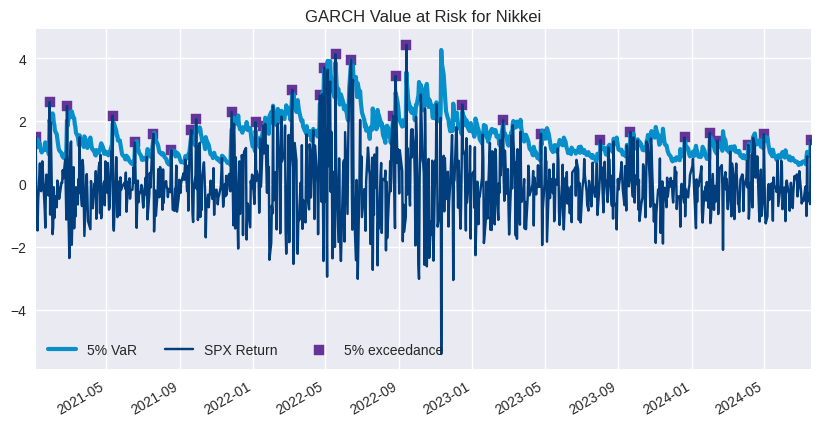

In [ ]:
am = arch_model(100*daily_return, vol="Garch", p=1, q=1, dist='StudentsT')
res = am.fit(disp="off", last_obs=dt.datetime(2020,12,31))

forecasts = res.forecast(start=dt.datetime(2021,1,1), reindex=False)
cond_mean = forecasts.mean["2021":]
cond_var = forecasts.variance["2021":]
q = am.distribution.ppf([0.05], res.params[-1:])

value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q
value_at_risk = pd.DataFrame(value_at_risk, columns=["5% VaR"], index=cond_var.index)

ax = value_at_risk.plot(figsize=(10,5),legend=False,color=color_light_blue)

rets = 100*daily_return["2021":].copy()
rets.name = "SPX Return"
(-rets).plot(color=color_dark_blue)

for line in ax.get_lines():
    if line.get_label() == "5% VaR":
        line.set_linewidth(3)

c = []
ret_index_var = []
ret_var = []

five = 0

for idx in value_at_risk.index:
    if rets[idx] <= -value_at_risk.loc[idx, "5% VaR"]:
        five = five + 1
        ret_index_var.append(idx)
        ret_var.append(-rets.loc[idx])

ax.scatter(
    ret_index_var,
    ret_var,
    marker="s",
    c=[purple],
    label="5% exceedance",
)

ax.set_title("GARCH Value at Risk for Nikkei")
leg = ax.legend(frameon=False, ncol=3)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])

print("StudentsT noise - Number of 5% exceedance: {:.2f}%".format(100*five/len(value_at_risk.index)))